In [1]:
"""
Created on August 4th 2022

@author: JJ
"""

'\nCreated on August 4th 2022\n\n@author: JJ\n'

In [2]:
import os, re, sys
import numpy as np
import pandas as pd
from math import log
import random
import scipy.io
import tensorflow as tf
import csv

2022-11-01 13:57:58.090265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import *
from tensorflow.keras.regularizers import *
#from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import (
    activations, 
    initializers, 
    regularizers, 
    constraints
)

In [4]:
num_threads = 8
# Maximum number of threads to use for OpenMP parallel regions.
os.environ["OMP_NUM_THREADS"] = "8"
# Without setting below 2 environment variables, it didn't work for me. Thanks to @cjw85 
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"
os.environ["TF_NUM_INTEROP_THREADS"] = "4"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

In [5]:
# in a well-defined initial state.
random.seed
np.random.seed(1337)
tf.random.set_seed(1337)

In [6]:
import matplotlib
import matplotlib.pyplot as plt

In [7]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping
)
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)
import keras_tuner as kt
from collections import defaultdict

In [92]:
path_dict = "/home/jjia1/viralepitope/"
pseq_dict = np.load(path_dict + 'pseq_dict_all.npy', allow_pickle = True).item()

In [85]:
def convert_alleleseq_to_pseudoseq(seq_dict):
    aa={"A":0,"R":1,"N":2,"D":3,"C":4,"Q":5,"E":6,"G":7,"H":8,"I":9,"L":10,"K":11,"M":12,"F":13,"P":14,"S":15,"T":16,"W":17,"Y":18,"V":19}

    residue_indices = list(range(0,34,1))
    #Now encode the MHC sequences into pseudo-sequences.
    for allele in seq_dict.keys():
        new_pseq = []
        pseq =""
        for index in residue_indices:
            pseq+= seq_dict[allele][index]
            new_pseq.append(seq_dict[allele]) 
        pseq_dict[allele] = new_pseq
    
    return pseq_dict

pseq_dict_converted = convert_alleleseq_to_pseudoseq(pseq_dict)

In [93]:
def mhc_peptide_pair(path, pseq_dict_matrix):
    aa={"A":0,"R":1,"N":2,"D":3,"C":4,"Q":5,"E":6,"G":7,"H":8,"I":9,"L":10,"K":11,"M":12,"F":13,"P":14,"S":15,"T":16,"W":17,"Y":18,"V":19}
    data_dict = {}
    pep_length = [8,9,10,11,12,13,14,15]
    f = open(path,"r")
    for line in f:
        info = re.split("\t",line)#Retrive information from a tab-delimited line
        allele = info[1].strip()
        if allele in pseq_dict_matrix.keys():
            affinity = int(info[-1].strip()) #Retrive lable information 
            pep = info[0].strip() #Retrive ligand information 
            
            if set(list(pep)).difference(list('ACDEFGHIKLMNPQRSTVWY')):
                print('Illegal peptides')
                continue   
            if len(pep) not in pep_length:
                print('Illegal peptides')
                continue 
                
            new_data = [pep, pseq_dict_matrix[allele], affinity]
            
            if allele not in data_dict.keys():
                data_dict[allele] = [new_data]
            else:
                data_dict[allele].append(new_data)
                
    return data_dict

In [94]:
pseudo_seq = mhc_peptide_pair('fulldata_withlabels_combined.txt', pseq_dict)

Illegal peptides
Illegal peptides
Illegal peptides
Illegal peptides
Illegal peptides
Illegal peptides


In [95]:
len(pseudo_seq)

121

In [96]:
training_data = []
for allele in pseudo_seq.keys():
    allele_data = pseudo_seq[allele]
    random.shuffle(allele_data)
    allele_data = np.array(allele_data)
    training_data.extend(allele_data)

In [97]:
[all_pep, all_mhc, all_target] = [[i[j] for i in training_data] for j in range(3)]

In [322]:
all_pepdf = pd.DataFrame(all_pep)
all_mhc_df = pd.DataFrame(all_mhc)
all_target_df = pd.DataFrame(all_target)

In [323]:
all_pepdf = pd.concat((all_pepdf,all_target_df), axis = 1)

In [297]:
all_mhcdf = pd.concat((all_mhc_df, all_target_df), axis = 1)

In [324]:
all_pepdf.columns = ['sequence', 'label']

In [305]:
all_mhcdf.columns = ['sequence', 'label']

In [333]:
pos = all_pepdf['label'] == '1'

In [334]:
all_pepdf_pos = all_pepdf[pos]
all_pepdf_neg = all_pepdf[~pos]

In [340]:
all_pepdf_pos

,sequence,label
1,TTFDAEYCR,1
31,NYLDYMTSMK,1
53,SISSVLTILY,1
61,MVLAFITFLR,1
64,MTSRMLLNR,1
...,...,...
945269,RRFFPYYVY,1
945275,RRFFPYYV,1
945298,YLEPAIAKY,1
945310,VEFEPPHAA,1


In [335]:
all_pepdf_neg

,sequence,label
0,PPRVLPLHP,0
2,KKFWVILKG,0
3,LLLHDSYDYD,0
4,EDEEGSESIS,0
5,AGRTKEAGK,0
...,...,...
945319,KKSNSAPSKKA,0
945320,ADKNRARVEEN,0
945321,LVTKTHLLSLS,0
945322,NQQHLQELQQE,0


In [341]:
all_pepdf_pos.shape

(85934, 2)

In [350]:
all_pepdf_pos = all_pepdf_pos.reset_index()
all_pepdf_neg = all_pepdf_neg.reset_index()

In [359]:
ofile = open('positive_viralepitope_sequenceonly.txt', 'w')
for i in range(all_pepdf_pos.shape[0]):
    ofile.write('>Sequence_'+str(i)+'\n'+all_pepdf_pos['sequence'][i]+'\n')
ofile.close()

In [361]:
ofile = open('negative_viralepitope_sequenceonly.txt', 'w')
for i in range(all_pepdf_neg.shape[0]):
    ofile.write('>Sequence_'+str(i)+'\n'+all_pepdf_neg['sequence'][i]+'\n')
ofile.close()

In [99]:
pep_df = pd.DataFrame(all_pep)
mhc_df = pd.DataFrame(all_mhc)
target_df = pd.DataFrame(all_target)

In [100]:
pep_df.columns = ['sequence']
pep_df['sequence'] = pep_df['sequence'].map(list)
pep_df

,sequence
0,"[P, P, R, V, L, P, L, H, P]"
1,"[T, T, F, D, A, E, Y, C, R]"
2,"[K, K, F, W, V, I, L, K, G]"
3,"[L, L, L, H, D, S, Y, D, Y, D]"
4,"[E, D, E, E, G, S, E, S, I, S]"
...,...
945319,"[K, K, S, N, S, A, P, S, K, K, A]"
945320,"[A, D, K, N, R, A, R, V, E, E, N]"
945321,"[L, V, T, K, T, H, L, L, S, L, S]"
945322,"[N, Q, Q, H, L, Q, E, L, Q, Q, E]"


In [101]:
mhc_df.columns = ['sequence']
mhc_df['sequence'] = mhc_df['sequence'].map(list)
mhc_df

,sequence
0,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
1,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
2,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
3,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
4,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
...,...
945319,"[Y, H, T, K, Y, R, E, I, S, T, N, T, Y, E, S, ..."
945320,"[Y, H, T, K, Y, R, E, I, S, T, N, T, Y, E, S, ..."
945321,"[Y, H, T, K, Y, R, E, I, S, T, N, T, Y, E, S, ..."
945322,"[Y, H, T, K, Y, R, E, I, S, T, N, T, Y, E, S, ..."


In [120]:
pep_df['id'] = pep_df.index
mhc_df['id'] = mhc_df.index

In [123]:
pep_df = pep_df[pep_df.columns[::-1]]
pep_df

,id,sequence
0,0,"[P, P, R, V, L, P, L, H, P]"
1,1,"[T, T, F, D, A, E, Y, C, R]"
2,2,"[K, K, F, W, V, I, L, K, G]"
3,3,"[L, L, L, H, D, S, Y, D, Y, D]"
4,4,"[E, D, E, E, G, S, E, S, I, S]"
...,...,...
945319,945319,"[K, K, S, N, S, A, P, S, K, K, A]"
945320,945320,"[A, D, K, N, R, A, R, V, E, E, N]"
945321,945321,"[L, V, T, K, T, H, L, L, S, L, S]"
945322,945322,"[N, Q, Q, H, L, Q, E, L, Q, Q, E]"


In [124]:
mhc_df = mhc_df[mhc_df.columns[::-1]]
mhc_df

,id,sequence
0,0,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
1,1,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
2,2,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
3,3,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
4,4,"[Y, T, A, M, Y, R, N, N, V, A, H, I, D, V, D, ..."
...,...,...
945319,945319,"[Y, H, T, K, Y, R, E, I, S, T, N, T, Y, E, S, ..."
945320,945320,"[Y, H, T, K, Y, R, E, I, S, T, N, T, Y, E, S, ..."
945321,945321,"[Y, H, T, K, Y, R, E, I, S, T, N, T, Y, E, S, ..."
945322,945322,"[Y, H, T, K, Y, R, E, I, S, T, N, T, Y, E, S, ..."


In [126]:
target_df['id'] = target_df.index
target_df = target_df[target_df.columns[::-1]]

In [150]:
target_df = target_df[0]

In [154]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
encoder.fit(all_target)
encoded_target = encoder.transform(all_target)

In [155]:
encoded_target

array([0, 1, 0, ..., 0, 0, 0])

In [129]:
import pandarallel
from sgt import SGT

In [137]:
alphabet = list('ACDEFGHIKLMNPQRSTVWY')

In [157]:
sgt_ = SGT(alphabets = alphabet, kappa =5, lengthsensitive = True, mode = 'multiprocessing', processors= 8)

In [158]:
pep_sgtembedding = sgt_.fit_transform(pep_df)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [159]:
pep_sgtembedding

,id,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,1.0,0.000000,0.077262,0.00000,0.570892,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.210019,0.0,0.0,0.0,0.0,0.000000
2,2.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,3.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.214492
4,4.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945319,945319.0,0.010884,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.070109,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
945320,945320.0,0.010884,0.000000,0.59427,0.061033,0.0,0.0,0.0,0.0,0.218620,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
945321,945321.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
945322,945322.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [160]:
mhc_sgtembedding = sgt_.fit_transform(mhc_df)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [161]:
mhc_sgtembedding

,id,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
0,0.0,0.070434,0.0,0.070435,0.0,0.0,0.0,0.52044,0.207632,0.0,...,0.207911,0.207911,0.0,0.564403,0.648329,0.000000,0.547268,0.027446,0.194820,0.067405
1,1.0,0.070434,0.0,0.070435,0.0,0.0,0.0,0.52044,0.207632,0.0,...,0.207911,0.207911,0.0,0.564403,0.648329,0.000000,0.547268,0.027446,0.194820,0.067405
2,2.0,0.070434,0.0,0.070435,0.0,0.0,0.0,0.52044,0.207632,0.0,...,0.207911,0.207911,0.0,0.564403,0.648329,0.000000,0.547268,0.027446,0.194820,0.067405
3,3.0,0.070434,0.0,0.070435,0.0,0.0,0.0,0.52044,0.207632,0.0,...,0.207911,0.207911,0.0,0.564403,0.648329,0.000000,0.547268,0.027446,0.194820,0.067405
4,4.0,0.070434,0.0,0.070435,0.0,0.0,0.0,0.52044,0.207632,0.0,...,0.207911,0.207911,0.0,0.564403,0.648329,0.000000,0.547268,0.027446,0.194820,0.067405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945319,945319.0,0.100789,0.0,0.273972,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.073050,0.0,0.000000,0.648329,0.202799,0.470527,0.025158,0.183226,0.364197
945320,945320.0,0.100789,0.0,0.273972,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.073050,0.0,0.000000,0.648329,0.202799,0.470527,0.025158,0.183226,0.364197
945321,945321.0,0.100789,0.0,0.273972,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.073050,0.0,0.000000,0.648329,0.202799,0.470527,0.025158,0.183226,0.364197
945322,945322.0,0.100789,0.0,0.273972,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.000000,0.073050,0.0,0.000000,0.648329,0.202799,0.470527,0.025158,0.183226,0.364197


In [162]:
import pickle as pkl
pkl.dump(pep_sgtembedding, open('peptide-sgt-embedding.pkl', 'wb'))
pkl.dump(mhc_sgtembedding, open('mhc-sgt-embedding.pkl', 'wb'))

In [163]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)    
allprobas_=np.array([]) 
all_labels=np.array([])

In [164]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
pep_sgtembedding.drop(columns = 'id', inplace = True)
mhc_sgtembedding.drop(columns = 'id', inplace = True)

In [206]:
#pep_sgtembedding, mhc_sgtembedding, encoded_target
train_pep, test_pep, train_mhc, test_mhc, train_target, test_target = train_test_split(pep_sgtembedding, mhc_sgtembedding, target_df, test_size = 0.2, stratify = target_df)

In [207]:
print(train_pep.shape)
print(test_pep.shape)

(756259, 400)
(189065, 400)


In [208]:
train_pep

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
159594,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
326641,0.468038,0.0,0.000000,0.0,0.468038,0.000000,0.000000,0.000000,0.000000,0.508256,...,0.0,0.0,0.58305,0.0,0.0,0.009309,0.0,0.214492,0.0,0.0
801647,0.000000,0.0,0.570892,0.0,0.000000,0.210019,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
414954,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
494311,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355546,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
862413,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.210019,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
148008,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029028,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
750675,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [209]:
train_target

159594    0
326641    0
801647    0
414954    0
494311    0
         ..
355546    0
862413    0
148008    0
750675    0
819564    0
Name: 0, Length: 756259, dtype: object

In [285]:
def build_model(training_pep, training_mhc):
    embed_dim = 32
    ff_dim = 32
    num_heads = 2

    input_pep = Input(shape=(training_pep.shape[1:]), name = 'peptide')
    input_mhc = Input(shape=(training_pep.shape[1:]), name = 'mhc')

    transformer_pep = TransformerBlock(embed_dim, num_heads, ff_dim)
    transformer_mhc = TransformerBlock(embed_dim, num_heads, ff_dim)

    x_pep = transformer_pep(input_pep)
    x_mhc = transformer_mhc(input_mhc)

    x_pep = GlobalAveragePooling1D()(x_pep)
    x_mhc = GlobalAveragePooling1D()(x_mhc)

    x_pep = Dropout(0.1)(x_pep)
    x_mhc = Dropout(0.1)(x_mhc)

    x_pep = Dense(20, activation = 'relu')(x_pep)
    x_mhc = Dense(20, activation = 'relu')(x_mhc)

    x_pep = Dropout(0.1)(x_pep)
    x_mhc = Dropout(0.1)(x_mhc)

    output_pep = Dense(1)(x_pep)
    output_mhc = Dense(1)(x_mhc)

    combined_output = concatenate([output_pep, output_mhc])
    combinedDense_output = Dense(1)(combined_output)
    output = Activation('sigmoid')(combinedDense_output)

    model = Model(inputs = [input_pep, input_mhc], outputs = output)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy', 'AUC'])
    model.summary()
    return model

In [227]:
encoder = LabelEncoder()
encoder.fit(train_target)
encoded_y = encoder.transform(train_target)

In [232]:
x_pep = pd.DataFrame(train_pep)
x_mhc = pd.DataFrame(train_mhc)

In [252]:
z = x_pep.iloc[1:10]
z_n = z.to_numpy()

In [286]:
folder = 'transformer/model/'
if not os.path.isdir(folder):
        os.makedirs(folder)

for i, (train_index, test_index) in enumerate(kfold.split(x_pep, encoded_y)):
    training_pep = x_pep.iloc[train_index]
    training_mhc = x_mhc.iloc[train_index]
    training_target = encoded_y[train_index]
    
    validation_pep = x_pep.iloc[test_index]
    validation_mhc = x_mhc.iloc[test_index]
    validation_target = encoded_y[test_index]
    
    training_pep = training_pep.to_numpy()
    training_mhc = training_mhc.to_numpy()
    validation_pep = validation_pep.to_numpy()
    validation_mhc = validation_mhc.to_numpy()
        
    callbacks_list = [
                ModelCheckpoint(filepath=(folder+'CV/model_%s.h5' %i), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True),
                EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 5)
        ]
    model = build_model(training_pep, training_mhc)
    model.summary()

    model.fit([training_pep,training_mhc], 
            training_target,
            batch_size=512,
            epochs = 100,
            shuffle=True,
            callbacks=callbacks_list,
            validation_data=([validation_pep,validation_mhc], validation_target),
            verbose=1)  
    del model

    saved_model = build_model(training_pep, training_mhc)
    saved_model.load_weights('model/CV/model_' +str(i)+'.h5')
    probas_ = saved_model.predict([np.array(validation_pep),np.array(validation_mhc)])
    allprobas_ = np.append(allprobas_, probas_)           
    all_labels = np.append(all_labels, validation_target)
    del saved_model


StagingError: in user code:

    /tmp/ipykernel_276440/749334574.py:14 call  *
        attn_output = self.att(inputs, inputs)
    /home/jjia1/miniconda3/envs/viralepitope/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /home/jjia1/miniconda3/envs/viralepitope/lib/python3.8/site-packages/tensorflow/python/keras/layers/multi_head_attention.py:473 call
        attention_output, attention_scores = self._compute_attention(
    /home/jjia1/miniconda3/envs/viralepitope/lib/python3.8/site-packages/tensorflow/python/keras/layers/multi_head_attention.py:438 _compute_attention
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
    /home/jjia1/miniconda3/envs/viralepitope/lib/python3.8/site-packages/tensorflow/python/keras/layers/multi_head_attention.py:401 _masked_softmax
        return self._softmax(attention_scores, attention_mask)
    /home/jjia1/miniconda3/envs/viralepitope/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/jjia1/miniconda3/envs/viralepitope/lib/python3.8/site-packages/tensorflow/python/keras/layers/advanced_activations.py:334 call
        return K.softmax(inputs, axis=self.axis[0])

    IndexError: tuple index out of range


0.9052241174663833
0.516624634633726
0.9035518794467714
0.5066978709224611
0.9042376237833235
0.5139765500698736
0.9071873900677148
0.5183374522677652


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.9062778942841268
0.5156445457573976


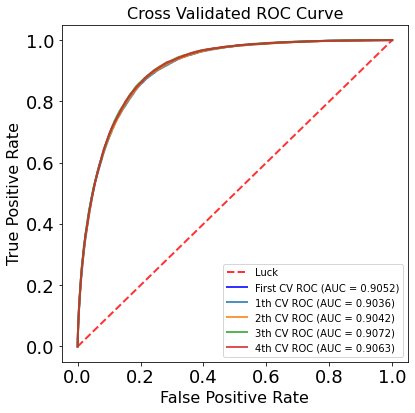

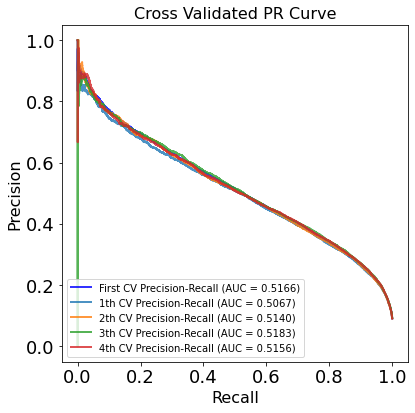

In [26]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
    training_pep = train_pep[train]
    training_mhc = train_mhc[train]
    training_target = train_target[train]
    
    validation_pep = train_pep[test]
    validation_mhc = train_mhc[test]
    validation_target = train_target[test]

    if i == 0:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/CV/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(validation_pep),np.array(validation_mhc)])
        allprobas_ = np.append(allprobas_, probas_)           
        all_labels = np.append(all_labels, validation_target)
        del saved_model

        fpr, tpr, thresholds = roc_curve(all_labels, allprobas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(all_labels, allprobas_)
        aupr = average_precision_score(all_labels, allprobas_)
        print(roc_auc)
        print(aupr)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr, color='b',
                label=r'First CV ROC (AUC = %0.4f)' % (roc_auc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(recall, precision, color='b',
                label=r'First CV Precision-Recall (AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")

    else:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/CV/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(validation_pep),np.array(validation_mhc)])
        allprobas_ = np.append(allprobas_, probas_)           
        all_labels = np.append(all_labels, validation_target)
        del saved_model
        
        fpr, tpr, thresholds = roc_curve(validation_target, probas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(validation_target, probas_)
        aupr = average_precision_score(validation_target, probas_)
        print(roc_auc)
        print(aupr)

        ax1.plot(fpr, tpr,
        label=str(i)+'th CV ROC (AUC = %0.4f)' % (roc_auc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(recall, precision, 
        label=str(i)+'th CV Precision-Recall (AUC = %0.4f)' % (aupr),
        lw=2, alpha=.8)
        ax2.legend(loc="lower left")

In [27]:
figure1.savefig('figures/5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')
figure2.savefig('figures/5_fold_prc.jpg', dpi=300, bbox_inches = 'tight')

0.9051786252722821


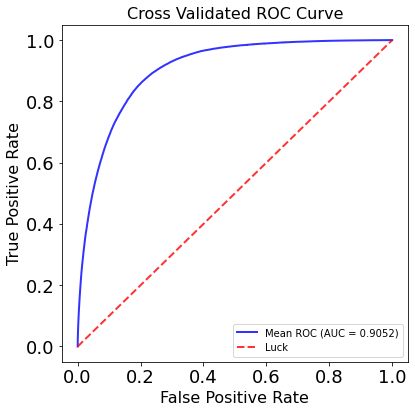

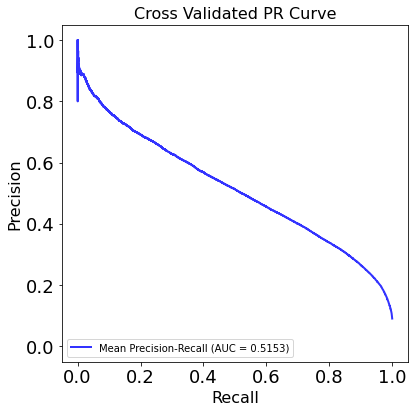

In [28]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels, allprobas_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
figure1.savefig('figures/mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels, allprobas_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels, allprobas_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
figure2.savefig('figures/mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')


In [29]:
allprobas2_=np.array([]) 
all_labels2=np.array([])

0.9092515463864606
0.530699913445114
0.903458717238532
0.5087277324404262
0.9040629165974562
0.5112839366124537
0.9054142670403028
0.5149869299267562
0.9056893464304572
0.513190421053872


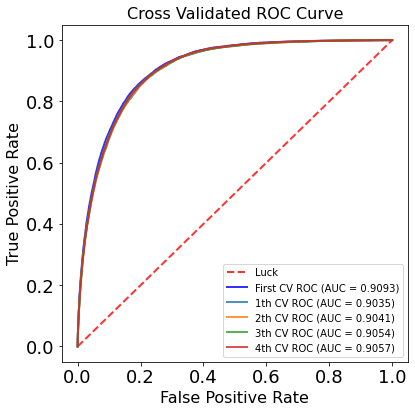

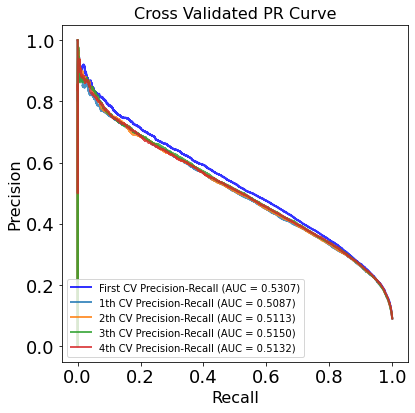

In [30]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for i in range(5):
    if i == 0:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/CV/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(test_pep),np.array(test_mhc)])
        allprobas2_ = np.append(allprobas2_, probas_)           
        all_labels2 = np.append(all_labels2, test_target)
        del saved_model

        fpr, tpr, thresholds = roc_curve(all_labels2, allprobas2_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(all_labels2, allprobas2_)
        aupr = average_precision_score(all_labels2, allprobas2_)
        print(roc_auc)
        print(aupr)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr, color='b',
                label=r'First CV ROC (AUC = %0.4f)' % (roc_auc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(recall, precision, color='b',
                label=r'First CV Precision-Recall (AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")

    else:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/CV/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(test_pep),np.array(test_mhc)])
        allprobas2_ = np.append(allprobas2_, probas_)           
        all_labels2 = np.append(all_labels2, test_target)
        del saved_model
        
        fpr, tpr, thresholds = roc_curve(test_target, probas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(test_target, probas_)
        aupr = average_precision_score(test_target, probas_)
        print(roc_auc)
        print(aupr)

        ax1.plot(fpr, tpr,
        label=str(i)+'th CV ROC (AUC = %0.4f)' % (roc_auc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(recall, precision, 
        label=str(i)+'th CV Precision-Recall (AUC = %0.4f)' % (aupr),
        lw=2, alpha=.8)
        ax2.legend(loc="lower left")

figure1.savefig('figures/test_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')
figure2.savefig('figures/test_5_fold_prc.jpg', dpi=300, bbox_inches = 'tight')

0.905341792791574


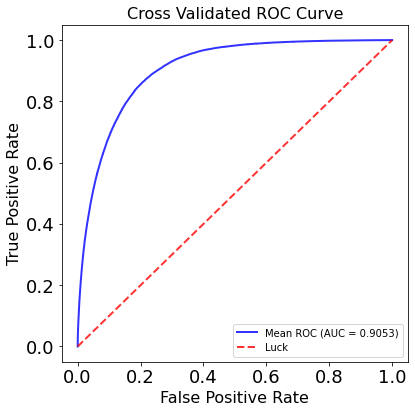

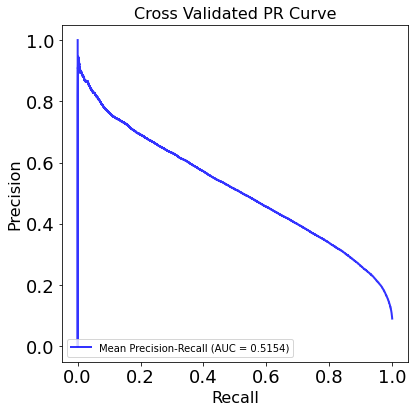

In [31]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels2, allprobas2_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
figure1.savefig('figures/test_mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels2, allprobas2_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels2, allprobas2_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
figure2.savefig('figures/test_mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')


In [32]:
from tensorflow.keras.models import load_model

In [ ]:
figure1, ax1 = plt.subplots(figsize=figsize)
figure2, ax2 = plt.subplots(figsize=figsize)
for i in range(5):
    saved_model = build_model(training_pep, training_mhc)
    saved_model = load_model('model/CV/model_'+str(i)+'.h5')

    ax1.plot(saved_model.history["loss"])
    ax1.plot(saved_model.history["val_loss"])
    ax1.legend(['train', 'test'], loc='best')
 
    ax2.plot(saved_model.history["accuracy"])
    ax2.plot(saved_model.history["val_accuracy"])
    ax2.legend(['train', 'test'], loc='best')

    del saved_model
